请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [1]:
# 加载飞桨、Numpy和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
class Regressor(paddle.nn.Layer):
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义一层全连接层，输入维度是1，输出维度是1
        self.fc = Linear(in_features=1, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc(inputs)
        return x

In [3]:
def load_data():
    # 加载数据
    data = np.loadtxt('./data/data.txt', delimiter=',', dtype=np.float32)
    #取800个数据作为训练集，70个数据作为测试集
    training_data, test_data = data[0:800], data[800:870]
    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做反归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(2):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:800]
    test_data = data[800:]
    return training_data, test_data

In [4]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()

# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

# 定义外层循环
EPOCH_NUM = 2001   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
                # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
    if epoch_id%100==0:
        print("epoch: {}, loss is: {}".format(epoch_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

epoch: 0, loss is: [0.01223645]
epoch: 100, loss is: [0.00487999]
epoch: 200, loss is: [0.01846288]
epoch: 300, loss is: [0.01701489]
epoch: 400, loss is: [0.01767637]
epoch: 500, loss is: [0.01670763]
epoch: 600, loss is: [0.00537646]
epoch: 700, loss is: [0.00675626]
epoch: 800, loss is: [0.01044488]
epoch: 900, loss is: [0.02330962]
epoch: 1000, loss is: [0.0083445]
epoch: 1100, loss is: [0.01138113]
epoch: 1200, loss is: [0.00631479]
epoch: 1300, loss is: [0.01140828]
epoch: 1400, loss is: [0.00349247]
epoch: 1500, loss is: [0.0165372]
epoch: 1600, loss is: [0.00668437]
epoch: 1700, loss is: [0.00997812]
epoch: 1800, loss is: [0.00742473]
epoch: 1900, loss is: [0.00574912]
epoch: 2000, loss is: [0.00873379]


In [5]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中


In [6]:
def random_one(data):
    # 随机抽取一个测试集样本进行检验
    data = test_data
    idx = np.random.randint(0, data.shape[0])

    dataone, label = data[idx, :-1], data[idx, -1]
    return dataone, label


In [7]:
# 参数为保存模型参数的文件地址
model_dict = paddle.load('LR_model.pdparams')
model.load_dict(model_dict)
# 开启模型校验模式
model.eval()

# 随机选取一个测试及数据进行检验
dataone, label = random_one(test_data)
# 将数据转为动态图的variable格式 
dataone = paddle.to_tensor(dataone)
predict = model(dataone)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

Inference result is [380.27344], the corresponding label is 376.0


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


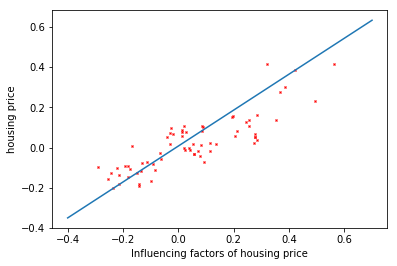

In [8]:
# 绘制测试集散点图及回归曲线判断训练效果
plt.figure()
x, y = test_data[:, :-1], test_data[:, -1] 
plt.xlabel("Influencing factors of housing price")
plt.ylabel("housing price")
plt.plot(x,y,"rx",markersize=2,markeredgewidth=1)
x1 = np.linspace(-0.4,0.7,100)
x2 = np.float32(x1)
y1 = np.zeros(100)
x2 = paddle.to_tensor(x2)


for i in range(100):
    y1[i] = model(x2[i])

plt.plot(x1, y1)
plt.show()